This version has:
- bootstrap
- updated noise fpeak prior, with edge effects addressed
- fpeak posteriors with edge effects addressed
- mismatched posterior and prior KDE (0.5 prior, 0.15 posterior)
- fpeak prior draw-up for posteriors
- Mchirp pop prior = 1
- no norm
- long BW posterior runs
- redshift correction, assuming known z
- updated ifo handling (better ifo specification and multiplication across fpeak posteriors)

In [41]:
## point to my utils/analysis code
hbpmloc = '/mnt/c/Users/Alexander/Documents/LIGO/PM/hbpm_v2/'
## basic imports
import numpy as np
import matplotlib.pyplot as plt
import mplcyberpunk
import scipy.stats as st
import matplotlib
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde as kde
from scipy.stats.mstats import mquantiles as mq
from pesummary.core.plots.bounded_1d_kde import bounded_1d_kde
from glob import glob
import pandas as pd
import sys 
import os
import pickle
from astropy import cosmology as co
from astropy.units import *
import dill
## Importing the accompanying utility and analysis files
sys.path.append(os.path.abspath(hbpmloc+'hbpm_utils/'))
from hbpm_utils import *
from importlib import reload
reload(sys.modules["hbpm_utils"])
from hbpm_utils import *
sys.path.append(hbpmloc)
from hbpm_analysis import run_analysis
reload(sys.modules["hbpm_analysis"])
from hbpm_analysis import run_analysis

## my preferred figure settings
matplotlib.rcParams['figure.figsize'] = (8.08, 5.)
matplotlib.rcParams['xtick.labelsize'] = 12.0
matplotlib.rcParams['ytick.labelsize'] = 12.0
matplotlib.rcParams['axes.labelsize'] = 14.0
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['axes.titlesize'] = 16
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=["mediumorchid", "teal", "goldenrod","slategray"])

In [42]:
post_bandwidth = 0.15
prior_bandwidth = 0.4

In [4]:
## load the not-bootstrap bootstrap
## really need a new name for this
## should also make a function to do this & put the samples in the hbpm_v2 directory
coeffs = pd.read_csv(
    '/mnt/c/Users/Alexander/Documents/LIGO/PM/hbpm/analysis_2022/empirical_relation_samples/sampled_coefficients_v05.tab',
    sep=' ')
bootstrap = coeffs.to_numpy()

## Preliminaries

In [43]:
## fine grid
fs = np.linspace(1.5,4,200)
Ms = np.linspace(0.8,1.8,200)

In [44]:
## get the Dietrich et al. (2020) multimessenger prior for R_1.6
Rs_mm, Rprior_kernel_mm, R16samples_mm = load_Rprior(hbpmloc+'/priors/R16_prior.txt',return_samples=True,plot=False)

## uniform prior, consider R on [9,15]
Rs = np.linspace(9,15,200)

In [45]:
uniform_Rprior = st.uniform(loc=Rs.min(),scale=(Rs.max()-Rs.min()))

In [8]:
## O5 prior
fprior_path = hbpmloc+'priors/fpeak_broad_O5_prior_100x.txt'
fprior_samples = np.loadtxt(fprior_path)
fprior = Prior_f(fprior_samples,boundary='Reflection',kde_bandwidth=prior_bandwidth)

In [9]:
with open(hbpmloc+'/priors/fpeak_O5_prior_bw0p4.pickle','wb') as file:
    dill.dump(fprior,file)

In [10]:
with open(hbpmloc+'/priors/fpeak_O5_prior_bw0p4.pickle','rb') as file:
    fprior_load = dill.load(file)

In [46]:
fprior_load

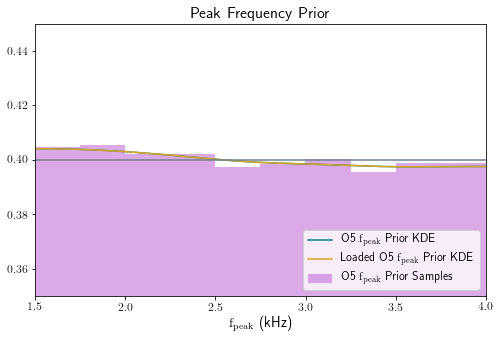

In [12]:
## plot the fpeak prior
plt.figure()
# plt.hist(O4_fprior.samples,density=True,alpha=0.5,label='O4 $\mathrm{f_{peak}}$'+' Prior Samples',bins=25)
plt.hist(fprior.samples,density=True,alpha=0.5,label='O5 $\mathrm{f_{peak}}$'+' Prior Samples',bins=10)
# plt.plot(fs,O4_fprior.pdf(fs),label='O4 $\\mathrm{f_{peak}}$ Prior KDE')
plt.plot(fs,fprior.pdf(fs),label='O5 $\\mathrm{f_{peak}}$ Prior KDE')
plt.plot(fs,fprior_load.pdf(fs),label='Loaded O5 $\\mathrm{f_{peak}}$ Prior KDE')
plt.plot(fs,st.uniform.pdf(fs,loc=1.5,scale=2.5))
plt.xlabel('$\mathrm{f_{peak}}$ (kHz)')
plt.xlim(1.5,4)
# plt.yticks([])
plt.ylim(0.35,0.45)
plt.title('Peak Frequency Prior')
plt.legend(loc='lower right')
# plt.savefig('fpeak_prior_forcapstone.jpg',bbox_inches='tight')
plt.show()

In [47]:
# fprior_spec = {'H1':fprior,'L1':fprior,'V1':fprior}
fprior_spec = hbpmloc+'/priors/fpeak_O5_prior_bw0p4_downsampled.pickle'
# fprior_spec = 'uniform'

## Analyses

In [48]:
# prior_O4 = O4_fprior #'/mnt/c/Users/Alexander/Documents/LIGO/PM/hbpm_v2/priors/fpeak_frankenstein_hnh_prior.txt'
# prior_O5 = 
savebase = '10-O4O5_allEoS_HLV'

## sly4

### O5

In [ ]:
sly4_O5_datadir = '/mnt/c/Users/Alexander/Documents/LIGO/PM/BWruns/HLV_runs/sly4_O5'
Rs_sly4_O5,likes_sly4_O5,post_sly4_O5,stats_sly4_O5,postdict_sly4_O5 = run_analysis(sly4_O5_datadir,
                                                                     fprior_spec,
                                                                'uniform','sly4',
                                                                hbpmloc+'/observing_run_sims/O5_events_updated.csv',
                                                               hbpmloc+'/nr_files/sly4_event_parameters.csv',
                                                               saveto='./'+savebase+'_sly4O5/',bootstrap=bootstrap,
                                                                 prior_bandwidth=prior_bandwidth,
                                                                 posterior_bandwidth=post_bandwidth,
                                                                        z_adj='known',Mchirp_scaling='snr',
                                                                   ifos='H1,L1,V1',aggregation='sum')

Running a hierarchical Bayesian post-merger analysis...
Loading priors...
Loading simulation data...
Generating event dictionary...


 67%|======>>>>| 56/83 [02:49<01:23,  3.10s/it]

### O4

In [ ]:
sly4_O4_datadir = '/mnt/c/Users/Alexander/Documents/LIGO/PM/BWruns/HLV_runs/sly4_O4'
Rs_sly4_O4,likes_sly4_O4,post_sly4_O4,stats_sly4_O4,postdict_sly4_O4 = run_analysis(sly4_O4_datadir,
                                                                     fprior_spec,
                                                                'uniform','sly4',
                                                                hbpmloc+'/observing_run_sims/O4_events_updated.csv',
                                                               hbpmloc+'/nr_files/sly4_event_parameters.csv',
                                                               saveto='./'+savebase+'_sly4O4/',bootstrap=bootstrap,
                                                                 prior_bandwidth=prior_bandwidth,
                                                                 posterior_bandwidth=post_bandwidth,
                                                                        z_adj='known',Mchirp_scaling='snr',
                                                                   ifos='H1,L1,V1',aggregation='sum')

In [ ]:
sly4_likes_O4O5 = [*likes_sly4_O4,*likes_sly4_O5]

In [ ]:
plt.figure()
ax = plt.gca()
# plot_aggregate_posterior_on_ax(Rs,likes_sly4,uniform_Rprior,Rtrue=11.54,ax=ax1,legend_loc='upper left',
#                          title='O4+O5 Posterior for sly4 EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
plot_aggregate_posterior_on_ax(Rs,sly4_likes_O4O5,uniform_Rprior,Rtrue=11.54,ax=ax,legend_loc='upper left',
                         title='O4+O5 Posterior for sly4 EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
# plot_aggregate_posterior_on_ax(Rs,likes_dd2,uniform_Rprior,Rtrue=13.26,ax=ax3,legend_loc='upper left',
#                          title='O4+O5 Posterior for dd2 EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
# ax1.set_ylim()
# plt.tight_layout()
# plt.savefig('../paper/figures/O4O5_allEoS_3panel_witherr.png',bbox_inches='tight')
# plt.savefig('../paper/figures/O4O5_allEoS_3panel_witherr.pdf',bbox_inches='tight')
plt.show()

In [ ]:
plt.figure()
ax = plt.gca()
# plot_aggregate_posterior_on_ax(Rs,likes_sly4,uniform_Rprior,Rtrue=11.54,ax=ax1,legend_loc='upper left',
#                          title='O4+O5 Posterior for sly4 EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
plot_aggregate_posterior_on_ax(Rs,sly4_likes_O4O5,Rprior_kernel_mm,Rtrue=11.54,ax=ax,legend_loc='upper left',
                         title='O4+O5 Posterior for sly4 EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
# plot_aggregate_posterior_on_ax(Rs,likes_dd2,uniform_Rprior,Rtrue=13.26,ax=ax3,legend_loc='upper left',
#                          title='O4+O5 Posterior for dd2 EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
# ax1.set_ylim()
# plt.tight_layout()
# plt.savefig('../paper/figures/O4O5_allEoS_3panel_witherr.png',bbox_inches='tight')
# plt.savefig('../paper/figures/O4O5_allEoS_3panel_witherr.pdf',bbox_inches='tight')
plt.show()

## SFHX

### O5

In [ ]:
sfhx_O5_datadir = '/mnt/c/Users/Alexander/Documents/LIGO/PM/BWruns/HLV_runs/sfhx_O5'
Rs_sfhx_O5z,likes_sfhx_O5z,post_sfhx_O5z,stats_sfhx_O5z,postdict_sfhx_O5z = run_analysis(sfhx_O5_datadir,
                                                                     fprior_spec,
                                                                'uniform','sfhx',
                                                                hbpmloc+'/observing_run_sims/O5_events_updated.csv',
                                                               hbpmloc+'/nr_files/sfhx_event_parameters.csv',
                                                               saveto='./'+savebase+'_sfhxO5/',bootstrap=bootstrap,
                                                                     prior_bandwidth=prior_bandwidth,
                                                                 posterior_bandwidth=post_bandwidth,
                                                                        z_adj='known',Mchirp_scaling='snr',
                                                                   ifos='H1,L1,V1',aggregation='sum')

### O4

In [ ]:
sfhx_O4_datadir = '/mnt/c/Users/Alexander/Documents/LIGO/PM/BWruns/HLV_runs/sfhx_O4'
Rs_sfhx_O4z,likes_sfhx_O4z,post_sfhx_O4z,stats_sfhx_O4z,postdict_sfhx_O4z = run_analysis(sfhx_O4_datadir,
                                                                     fprior_spec,
                                                                'uniform','sfhx',
                                                                hbpmloc+'/observing_run_sims/O4_events_updated.csv',
                                                               hbpmloc+'/nr_files/sfhx_event_parameters.csv',
                                                               saveto='./'+savebase+'_sfhxO4/',bootstrap=bootstrap,
                                                                     prior_bandwidth=prior_bandwidth,
                                                                 posterior_bandwidth=post_bandwidth,
                                                                        z_adj='known',Mchirp_scaling='snr',
                                                                   ifos='H1,L1,V1',aggregation='mult')

In [ ]:
sfhx_likes_O4O5z = [*likes_sfhx_O4z,*likes_sfhx_O5z]

In [ ]:
plt.figure()
ax = plt.gca()
# plot_aggregate_posterior_on_ax(Rs,likes_sly4,uniform_Rprior,Rtrue=11.54,ax=ax1,legend_loc='upper left',
#                          title='O4+O5 Posterior for sly4 EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
plot_aggregate_posterior_on_ax(Rs,sfhx_likes_O4O5z,uniform_Rprior,Rtrue=11.98,ax=ax,legend_loc='upper left',
                         title='O4+O5 Posterior for SFHX EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
# plot_aggregate_posterior_on_ax(Rs,likes_dd2,uniform_Rprior,Rtrue=13.26,ax=ax3,legend_loc='upper left',
#                          title='O4+O5 Posterior for dd2 EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
# ax1.set_ylim()
# plt.tight_layout()
# plt.savefig('../paper/figures/O4O5_allEoS_3panel_witherr.png',bbox_inches='tight')
# plt.savefig('../paper/figures/O4O5_allEoS_3panel_witherr.pdf',bbox_inches='tight')
plt.show()

In [ ]:
plt.figure()
ax = plt.gca()
# plot_aggregate_posterior_on_ax(Rs,likes_sly4,uniform_Rprior,Rtrue=11.54,ax=ax1,legend_loc='upper left',
#                          title='O4+O5 Posterior for sly4 EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
plot_aggregate_posterior_on_ax(Rs,sfhx_likes_O4O5z,Rprior_kernel_mm,Rtrue=11.98,ax=ax,legend_loc='upper left',
                         title='O4+O5 Posterior for SFHX EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
# plot_aggregate_posterior_on_ax(Rs,likes_dd2,uniform_Rprior,Rtrue=13.26,ax=ax3,legend_loc='upper left',
#                          title='O4+O5 Posterior for dd2 EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
# ax1.set_ylim()
# plt.tight_layout()
# plt.savefig('../paper/figures/O4O5_allEoS_3panel_witherr.png',bbox_inches='tight')
# plt.savefig('../paper/figures/O4O5_allEoS_3panel_witherr.pdf',bbox_inches='tight')
plt.show()

## DD2

### O5

In [ ]:
dd2_O5_datadir = '/mnt/c/Users/Alexander/Documents/LIGO/PM/BWruns/HLV_runs/dd2_O5'
Rs_dd2_O5z,likes_dd2_O5z,post_dd2_O5z,stats_dd2_O5z,postdict_dd2_O5z = run_analysis(dd2_O5_datadir,
                                                                     fprior_spec,
                                                                'uniform','dd2',
                                                                hbpmloc+'/observing_run_sims/O5_events_updated.csv',
                                                               hbpmloc+'/nr_files/dd2_event_parameters.csv',
                                                               saveto='./'+savebase+'_dd2O5/',bootstrap=bootstrap,
                                                                     prior_bandwidth=prior_bandwidth,
                                                                 posterior_bandwidth=post_bandwidth,
                                                                        z_adj='known',Mchirp_scaling='snr',
                                                                   ifos='H1,L1,V1',aggregation='sum')

### O4

In [ ]:
dd2_O4_datadir = '/mnt/c/Users/Alexander/Documents/LIGO/PM/BWruns/HLV_runs/dd2_O4'
Rs_dd2_O4z,likes_dd2_O4z,post_dd2_O4z,stats_dd2_O4z,postdict_dd2_O4z = run_analysis(dd2_O4_datadir,
                                                                     fprior_spec,
                                                                'uniform','dd2',
                                                                hbpmloc+'/observing_run_sims/O4_events_updated.csv',
                                                               hbpmloc+'/nr_files/dd2_event_parameters.csv',
                                                               saveto='./'+savebase+'_dd2O4/',bootstrap=bootstrap,
                                                                     prior_bandwidth=prior_bandwidth,
                                                                 posterior_bandwidth=post_bandwidth,
                                                                        z_adj='known',Mchirp_scaling='snr',
                                                                   ifos='H1,L1,V1',aggregation='sum')

In [ ]:
dd2_likes_O4O5z = [*likes_dd2_O4z,*likes_dd2_O5z]

In [ ]:
plt.figure()
ax = plt.gca()
# plot_aggregate_posterior_on_ax(Rs,likes_sly4,uniform_Rprior,Rtrue=11.54,ax=ax1,legend_loc='upper left',
#                          title='O4+O5 Posterior for sly4 EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
plot_aggregate_posterior_on_ax(Rs,dd2_likes_O4O5z,uniform_Rprior,Rtrue=13.26,ax=ax,legend_loc='upper left',
                         title='O4+O5 Posterior for dd2 EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
# plot_aggregate_posterior_on_ax(Rs,likes_dd2,uniform_Rprior,Rtrue=13.26,ax=ax3,legend_loc='upper left',
#                          title='O4+O5 Posterior for dd2 EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
# ax1.set_ylim()
# plt.tight_layout()
# plt.savefig('../paper/figures/O4O5_allEoS_3panel_witherr.png',bbox_inches='tight')
# plt.savefig('../paper/figures/O4O5_allEoS_3panel_witherr.pdf',bbox_inches='tight')
plt.show()

In [ ]:
plt.figure()
ax = plt.gca()
# plot_aggregate_posterior_on_ax(Rs,likes_sly4,uniform_Rprior,Rtrue=11.54,ax=ax1,legend_loc='upper left',
#                          title='O4+O5 Posterior for sly4 EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
plot_aggregate_posterior_on_ax(Rs,dd2_likes_O4O5z,Rprior_kernel_mm,Rtrue=13.26,ax=ax,legend_loc='upper left',
                         title='O4+O5 Posterior for dd2 EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
# plot_aggregate_posterior_on_ax(Rs,likes_dd2,uniform_Rprior,Rtrue=13.26,ax=ax3,legend_loc='upper left',
#                          title='O4+O5 Posterior for dd2 EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
# ax1.set_ylim()
# plt.tight_layout()
# plt.savefig('../paper/figures/O4O5_allEoS_3panel_witherr.png',bbox_inches='tight')
# plt.savefig('../paper/figures/O4O5_allEoS_3panel_witherr.pdf',bbox_inches='tight')
plt.show()

## All together now!

In [ ]:
## plot all
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,4),sharey=True)
plot_aggregate_posterior_on_ax(Rs,sly4_likes_O4O5,uniform_Rprior,Rtrue=11.54,ax=ax1,legend_loc='upper left',
                         title='O4+O5 Posterior for sly4 EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
plot_aggregate_posterior_on_ax(Rs,sfhx_likes_O4O5z,uniform_Rprior,Rtrue=11.98,ax=ax2,legend_loc='upper left',
                         title='O4+O5 Posterior for SFHX EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
plot_aggregate_posterior_on_ax(Rs,dd2_likes_O4O5z,uniform_Rprior,Rtrue=13.26,ax=ax3,legend_loc='upper left',
                         title='O4+O5 Posterior for dd2 EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
ax1.set_ylim(0,0.015)
plt.tight_layout()
# plt.suptitle('O4+O5')
# plt.savefig('../paper/figures/O4O5_allEoS_uniformprior_3panel.png',bbox_inches='tight')
# plt.savefig('../paper/figures/O4O5_allEoS_uniformprior_3panel.pdf',bbox_inches='tight')
plt.show()

In [ ]:
## plot all
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,4),sharey=True)
plot_aggregate_posterior_on_ax(Rs,likes_sly4_O5,uniform_Rprior,Rtrue=11.54,ax=ax1,legend_loc='upper left',
                         title='O5 Posterior for sly4 EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
plot_aggregate_posterior_on_ax(Rs,likes_sfhx_O5z,uniform_Rprior,Rtrue=11.98,ax=ax2,legend_loc='upper left',
                         title='O5 Posterior for SFHX EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
plot_aggregate_posterior_on_ax(Rs,likes_dd2_O5z,uniform_Rprior,Rtrue=13.26,ax=ax3,legend_loc='upper left',
                         title='O5 Posterior for dd2 EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
ax1.set_ylim(0,0.02)
plt.tight_layout()
# plt.suptitle('O5 Only')
# plt.savefig('../paper/figures/O4O5_allEoS_uniformprior_3panel.png',bbox_inches='tight')
# plt.savefig('../paper/figures/O4O5_allEoS_uniformprior_3panel.pdf',bbox_inches='tight')
plt.show()

In [ ]:
## plot all
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,4),sharey=True)
plot_aggregate_posterior_on_ax(Rs,likes_sly4_O4,uniform_Rprior,Rtrue=11.54,ax=ax1,legend_loc='upper left',
                         title='O4 Posterior for sly4 EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
plot_aggregate_posterior_on_ax(Rs,likes_sfhx_O4z,uniform_Rprior,Rtrue=11.98,ax=ax2,legend_loc='upper left',
                         title='O4 Posterior for SFHX EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
plot_aggregate_posterior_on_ax(Rs,likes_dd2_O4z,uniform_Rprior,Rtrue=13.26,ax=ax3,legend_loc='upper left',
                         title='O4 Posterior for dd2 EoS')#,Rticks=[9.5,10,10.5,11,11.5,12,12.5,13,13.5])
ax1.set_ylim(0,0.013)
plt.tight_layout()
# plt.suptitle('O4 Only')
# plt.savefig('../paper/figures/O4O5_allEoS_uniformprior_3panel.png',bbox_inches='tight')
# plt.savefig('../paper/figures/O4O5_allEoS_uniformprior_3panel.pdf',bbox_inches='tight')
plt.show()

In [ ]:
Rs_fine = np.linspace(9,15,500)
plt.figure()
plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(sly4_likes_O4O5),uniform_Rprior),
         label='sly4 analysis',color='mediumorchid')
plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(sfhx_likes_O4O5z),uniform_Rprior),
         label='sfhx analysis',color='teal')
plt.plot(Rs,get_posterior(Rs,get_aggregate_likelihood(dd2_likes_O4O5z),uniform_Rprior),
         label='dd2 analysis',color='goldenrod')
plt.axvline(11.54,color='mediumorchid',ls='-.',label='sly4 $\mathrm{R_{1.6}}$')
plt.axvline(11.98,color='teal',ls='-.',label='sly4 $\mathrm{R_{1.6}}$')
plt.axvline(13.26,color='goldenrod',ls='-.',label='sly4 $\mathrm{R_{1.6}}$')
# plt.axhline(0.005,label='Prior')
# plt.ylim(0,0.01)
plt.xlabel('$R_{1.6}$ (km)')
plt.xlim(10,14)
plt.legend(bbox_to_anchor=(1,0.4))
plt.show()